

## Introduction

For this project I will look at completing two objectives.
- The first objective is: To predict the price of mens shoes based upon a variety of categorical properties with an accuracy of over 20% above the baseline.
- The second objective is: Given a sample photo of a shoe I would like to be able to recommend a similar shoe from an online retailer with a 70% accuracy.
 
My target audience is customers know what they want but want to avoid spending hours finding the right shoe and ‘shopping around’ for the best deal. 

I want to be able to tell customers for a picture of a desired shoe you have X range of brands and this is what is likely to cost given a particular brand/retailer combination.

I have collected data from 5 'high fashion' brand websites in the notebook **Web_Scraping.ipynb** the data includes the following infromation: Retailer, Brand, Description and Price. I have also scraped information but I will process this separately.

## EDA

In this workbook I will clean the data and try and extract any underlying information. I will aim to complete the following activities:
Text Data - As with all text datasets I expect there to be spelling errors, different ways to spelling brands, punctuation etc.
Price Data - Some of the Price data has been provided in ranges, this needs to be averaged.
Shoe Type - I will try and extract the various types of shoes from the descriptions in order to use them as a possible classification target.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import datetime as dt
% matplotlib inline
from difflib import SequenceMatcher

/Users/annacrawford/anaconda/envs/Zaincorp/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
## Connect to local database
engine=create_engine('postgresql://localhost:5432/capstone_project')
Data=pd.read_sql_table('mens_shoes',con=engine)

In [3]:
## Preview of the data scrapped from the retail websites.
Data.head(2)

,id,brand,retailer,description,image_url,image_url_alt,price,date
0,728,Alexander McQueen,Matches_Fashion,Raised-sole high-top leather trainers,http://assetsprx.matchesfashion.com/img/produc...,http://assetsprx.matchesfashion.com/img/produc...,395,2016-11-22
1,729,Armando Cabral,Matches_Fashion,Lace-up leather derby shoes,http://assetsprx.matchesfashion.com/img/produc...,http://assetsprx.matchesfashion.com/img/produc...,405,2016-11-22


As you can see the majority of the data is text based, and with it comes in the inherant problems of different ways of spelling, spelling mistakes, capital letters and symbols. The first section of this workbook will focus on data cleaning. I will work through the each of the categories below, cleaning them before performing some exploritory data analysis.

### Brand Data
Initally I will check to see if there are any brands that have been written in different ways on the various websites, I will then ensure that there is one format for each brand. Once I have a consistant set of labels I will remove any brands that have less then 20 shoes for sale across the 5 e-commerce sites.
In order to find similar names I will first sort all of the unique brands from the database, I will then use a function called SequenceMatcher, this function finds the difference between strings and words, and provides a numerical value for this distance. I will use the following method.
1. Sort the brands alphabetically.
2. Create a column called 'Brand Below' that contains all the brands but shifted one row up.
3. I will create two columns of the first word, of the brand and the brand below for each row.
4. I will calculate the distance between the the first word of the brand and the first word of the brand below.
5. I will repeat 4 for the full brand string.
6. If the first word of the brnad is the same and the similarty between the full string is above 0.5 I will examine them further.

In [4]:
## I will change of the text to lower case in order to create a common format.
Data.brand=Data.brand.str.lower()
Data.description=Data.description.str.lower()
## Creating a dataframe that contains all of the unique spellings of brands from the 5 sites.
Brand_List=pd.DataFrame(Data.brand.unique(),columns=['Brand'])

In [5]:
## I will sort the Brands alphabetically so that any similar names with slight chnages should appear one together.
Brand_List=Brand_List.sort_values(by='Brand').reset_index()
## Creating a column with a list of the brands shifted up 1 row.
Brand_List['Brand_Below']=Brand_List.Brand
Brand_List.Brand_Below=Brand_List.Brand_Below.shift(-1)
## Dropping the last row
Brand_List=Brand_List.dropna()

In [6]:
## Creating columns with the first word of the brand and the brand below.
Brand_List['Brand_first_word']=Brand_List.Brand.map(lambda x: x.split(' ')[0])
Brand_List['Brand_below_first_word']=Brand_List.Brand_Below.map(lambda x: x.split(' ')[0])

In [7]:
## Applying the sequence match function to find the distance between the brand strings.
Brand_List['Difference']=Brand_List.apply(
    lambda x: SequenceMatcher(None, x['Brand'], x['Brand_Below']).ratio(),axis=1)

In [8]:
## Applying the sequence match function to find the distance between the first word of the brand strings.
Brand_List['FW_Difference']=Brand_List.apply(
    lambda x: SequenceMatcher(None, x['Brand_first_word'], x['Brand_below_first_word']).ratio(),axis=1)

In [9]:
## This is what the resulting list looks like.
Brand_List.head(10)

,index,Brand,Brand_Below,Brand_first_word,Brand_below_first_word,Difference,FW_Difference
0,258,11 by boris bidjan saberi,a diciannoveventitre,11,a,0.311111,0.000000
1,187,a diciannoveventitre,a. testoni,a,a.,0.200000,0.666667
2,387,a. testoni,a.f.vandevorst,a.,a.f.vandevorst,0.416667,0.250000
3,174,a.f.vandevorst,a.p.c.,a.f.vandevorst,a.p.c.,0.300000,0.300000
4,24,a.p.c.,abbeyhorn,a.p.c.,abbeyhorn,0.133333,0.133333
5,90,abbeyhorn,acne studios,abbeyhorn,acne,0.285714,0.307692
6,56,acne studios,adidas,acne,adidas,0.444444,0.200000
7,268,adidas,adidas by day one,adidas,adidas,0.521739,1.000000
8,67,adidas by day one,adidas by kolor,adidas,adidas,0.687500,1.000000
9,69,adidas by kolor,adidas by raf simons,adidas,adidas,0.628571,1.000000


In [10]:
## I will now filter the list, with the condition that the first word of similar brands must be the same, and the
## the string similarity must be over 0.5.
Output=Brand_List[Brand_List.FW_Difference==1][Brand_List.Difference>0.5]
Output

/Users/annacrawford/anaconda/envs/Zaincorp/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,index,Brand,Brand_Below,Brand_first_word,Brand_below_first_word,Difference,FW_Difference
7,268,adidas,adidas by day one,adidas,adidas,0.521739,1.0
8,67,adidas by day one,adidas by kolor,adidas,adidas,0.687500,1.0
9,69,adidas by kolor,adidas by raf simons,adidas,adidas,0.628571,1.0
10,162,adidas by raf simons,adidas by rick owens,adidas,adidas,0.750000,1.0
11,247,adidas by rick owens,adidas by white mountaineering,adidas,adidas,0.520000,1.0
13,121,adidas originals,adidas originals by wings + horns,adidas,adidas,0.653061,1.0
17,234,alberto fasciani,alberto premi,alberto,alberto,0.620690,1.0
20,0,alexander mcqueen,alexander wang,alexander,alexander,0.709677,1.0
31,175,ann demeulemeester,ann demeulemeester blanche,ann,ann,0.818182,1.0
85,35,christian louboutin,christian pellizzari,christian,christian,0.615385,1.0


It is visibile that there are a number of dusplicate brands with some minor changes in the way they are written. However there are also a large number of different brands. I will now manually match the correct duplicates and remove the others. In some cases there is more then one spellling or the 'Brand_Below' column string is more correct then the 'Brand' column string, in these cases I will drop the rows and create a dictionary that will replace the incorrect strings. In all other cases I will replace the 'Brand_Below' String with the 'Brand' String for each applicable row.

In [11]:
## Remove applicable rows
Output=Output.drop([7,8,9,10,11,13,17,20,85,189,190,225,272,293,294,328])
## Create a dictionary of the strings to replace
Brand_Name_Rep=dict(zip(Output.Brand_Below,Output.Brand))
## Create a manual dictionary for the strings that are not included in the dictionary above.
Temp_Dict={'salvatore ferragmao':'salvatore ferragamo','salvatore ferrgamo':'salvatore ferragamo',
               'versus versace':'versace','raf simons x adidas':'adidas by raf simons',
               'paul smith jeans':'paul smith','paul smith shoe':'paul smith',
               'paul smith shoes & accessories':'paul smith','nike tennis':'nike','nike running':'nike',
               'nike training':'nike','comme des garçons play':'comme des garçons',
               'comme des garçons shirt':'comme des garçons','adidas originals':'adidas',
               'martin margiela':'maison margiela'}
## Join the two dictionaries together.
Brand_Name_Rep.update(Temp_Dict)

In [12]:
## Replace al of the strings in the main dataframe with the corrected strings.
Data.brand=Data.brand.map(lambda x: Brand_Name_Rep[x] if x in Brand_Name_Rep.keys() else x)

/Users/annacrawford/anaconda/envs/Zaincorp/lib/python2.7/site-packages/ipykernel/__main__.py:2: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  from ipykernel import kernelapp as app


I will now remove all brands that do not have at least 20 shoes between the 5 retailers, as I suspect the brand coefficents will dominate the model, I think that those with a low sample of shoes will have in accurate results.

In [13]:
## Create a list of all the brands with less then 20 shoes.
Brand_Count=pd.DataFrame(Data.brand.value_counts()).reset_index()
Brands_to_Drop=Brand_Count[Brand_Count.brand<20]['index']

In [14]:
## Drop the brands with less then 20 shoes.
Data=Data[~Data.brand.isin(Brands_to_Drop)]

### Description Data
The description data has similar problems with the brand data, some retailers user the term hi-top, others high-top and possibly even 'hightop'. I will therefore repeat a similar process of string cleaning. I will focus on words that describe the type of shoe as I feel this will have a bigger impact on the price, as well as allowing me to use the types of shoes as a classification for for further ananlysis. Intially I will remove some punctuation that is not necessary including ',' and ':'. I will replace the '-'  with a space but not before converting the high top terms to a single word.

In this case I will compare each of the words with those above and below alphabetically as it is likely that there will be three or more occurances of some similar words. I will also use a threshhold of 0.7 for the similarty, above which I will examine and try to replace where necessary. For this section I am looking for words with at least 100 occurances as these are more likely to be the shoe types rather then general descriptors. As this number could be combined from two words with slightly differening spelling I will set my cut off at 50 untill the words have been cleaned.

In [15]:
## Remove commas and colons.
Data.description=Data.description.map(lambda x: ''.join([a for a in x if a not in "',:"]))
## Replace hiphonated words with single strings
Data.description=Data.description.map(lambda x: x.replace('high-top','hightop'))
Data.description=Data.description.map(lambda x: x.replace('hi-top','hightop'))
## Replace hyphons with spaces
Data.description=Data.description.map(lambda x: x.replace('-',' '))

In [16]:
## Create a new dataframe listing each words within the description strings, and the number of occurances.
Description_Words=pd.DataFrame(pd.Series(' '.join(Data.description).lower().split()).value_counts(),
                        columns=['Count']).reset_index()
## Re-title colums and sort words alphabetically
Description_Words=Description_Words.rename(columns={'index':'Word'})
Description_Words=Description_Words.sort_values(by='Word').reset_index()
Description_Words=Description_Words.drop('index',axis=1)
Description_Words.head()

,Word,Count
0,&,97
1,+,23
2,0,1
3,0003,3
4,01,3


In [17]:
## Create two columns for words below and words above, copying the original word but shifting the data.
Description_Words['Word_Below']=Description_Words['Word'].shift(-1)
Description_Words['Word_Above']=Description_Words['Word'].shift(1)
Description_Words=Description_Words.dropna()
## Calculating the difference between the original word and the word above and below.
Description_Words['Difference']=Description_Words.apply(
    lambda x: SequenceMatcher(None, x['Word'], x['Word_Below']).ratio(),axis=1)
Description_Words['Difference2']=Description_Words.apply(
    lambda x: SequenceMatcher(None, x['Word'], x['Word_Above']).ratio(),axis=1)
Description_Words.head()

,Word,Count,Word_Below,Word_Above,Difference,Difference2
1,+,23,0,&,0.000000,0.000000
2,0,1,0003,+,0.400000,0.000000
3,0003,3,01,0,0.333333,0.400000
4,01,3,02,0003,0.500000,0.333333
5,02,1,04,01,0.500000,0.500000


In [18]:
## Apply a threshold of above 0.7 and limit the words to only those with above 50 occurances. I will then sort the 
## data by difference values so that I can process the similarities between words above and below seperately.
Mask1=Description_Words.Difference>0.7
Mask2=Description_Words.Difference2>0.7
Output_2=Description_Words[Mask1][Description_Words.Count>50].sort_values(by='Difference',ascending=False)
Output_2

/Users/annacrawford/anaconda/envs/Zaincorp/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Word,Count,Word_Below,Word_Above,Difference,Difference2
118,achilles,53,achillies,achiles,0.941176,0.933333
2164,slippers,156,slipperss,slipper,0.941176,0.933333
526,classic,630,classics,clasp,0.933333,0.666667
1140,hightop,1006,hightops,high,0.933333,0.727273
2179,sneaker,106,sneakers,snap,0.933333,0.545455
2180,sneakers,5076,sneakes,sneaker,0.933333,0.933333
1394,loafers,637,loafters,loafer,0.933333,0.923077
1740,oxford,229,oxfords,owl,0.923077,0.222222
408,buckle,51,buckled,buckinhan,0.923077,0.533333
389,brogue,132,brogues,brocade,0.923077,0.615385


In [19]:
## Selecting the rows that will be used for the string replace and creating a dictionary of the rows.
Output_2=Output_2.ix[[796,1869,1769,2319,620,1314,579,2188,408],:]
Description_Repl=dict(zip(Output_2.Word_Below,Output_2.Word))

In [20]:
## Creating a dictionary of additional string replacements.
Description_Repl2={'shoe':'shoes','runner':'runners','paneled':'panelled','panel':'panelled',
                   'loafer':'loafers','grained':'grainy','grained':'grainy','brogue':'brogues',
                   'bootie':'boots','boot':'boots','achilles':'achillies','achiles':'achillies',
                   'slipperss':'slippers','slipper':'slippers','sneakes':'sneakers','sneaker':'sneakers',
                   'chukk':'chukka','emboss':'embossed','detail':'detailing','hightop':'hightops'}
Description_Repl.update(Description_Repl2)

In [21]:
## Repeat the process with the data with a higer difference ration for the word below.
Output_3=Description_Words[Mask2][Description_Words.Count>50][Description_Words.Difference<0.7]\
            .sort_values(by='Difference',ascending=False)
Output_3

/Users/annacrawford/anaconda/envs/Zaincorp/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


,Word,Count,Word_Below,Word_Above,Difference,Difference2
2264,strap,201,strapiatta,strand,0.666667,0.727273
2035,sandals,87,sandstone,sandal,0.625000,0.923077
2278,studded,99,studio,stud,0.615385,0.727273
2111,shoes,1288,short,shoe,0.600000,0.888889
741,drivers,78,driving,driver,0.571429,0.923077
2390,trainers,383,trainspotting,trainer,0.571429,0.933333
1518,metallic,58,mexico,metal,0.571429,0.769231
702,detailing,56,detroit,detailed,0.500000,0.705882
2565,wingtip,90,winner,wing,0.461538,0.727273
390,brogues,270,brooch,brogue,0.461538,0.923077


In [22]:
## Dropping un-needed rows and creating a dictionary.
Output_3=Output_3.drop([1141,2290,351,2565,2264])
Description_Repl2=dict(zip(Output_3.Word_Above,Output_3.Word))

In [23]:
## Join the two dictionarys together.
Description_Repl.update(Description_Repl2)

In [24]:
## This function will iterate through each word in a string and if that word is in the dictionary created above
## it will replace it appropriately.
def string_replace(inp_str):
    string_list=inp_str.split(' ')
    for x in range(len(string_list)):
        word=string_list[x]
        if word in Description_Repl.keys():
            string_list[x]=Description_Repl[word]
    return ' '.join(string_list)

In [25]:
## Apply the function above to each description in the dataframe.
Data.description=Data.description.apply(lambda x: string_replace(x))

In [26]:
## Create a dataframe of all of the cleaned words in the descritptions section.
Cleaned_Description_Words=pd.DataFrame(pd.Series(' '.join(Data.description).lower().split()).value_counts(),
                        columns=['Count']).reset_index()

In [28]:
## Generate a list of key words with more then 100 occurances as these will likely by all of the shoe types.
Cleaned_Description_Words[Cleaned_Description_Words.Count>100]

,index,Count
0,sneakers,5183
1,leather,2111
2,boots,1552
3,shoes,1431
4,hightops,1132
5,lace,872
6,up,836
7,suede,829
8,loafers,719
9,classic,630


### Price Cleaning
There is less work required in cleaning the price information as the majority of this was completed in the scraping process. Firstly a number of values were provided with a comma such as '1,000' these will be removed. Also suprisingly on some sites the values were provided as a range, I assume this was related to shoe size or perhaps colour. For these values I will take the average of the range.

In [29]:
## The function below removes all the commmas and averages the any values that are provided as a range.
def price_avg(Inp_Str):
    Inp_Str=Inp_Str.replace(',','')
    if '-' in Inp_Str:
        Values=Inp_Str.split('-')
        Values=[float(x) for x in Values]
        return np.mean(Values)
    else:
        return float(Inp_Str)

In [30]:
## Applying the function above to all of the price data in the dataframe.
Data.price=Data.price.map(lambda x: price_avg(x))

In [31]:
## Check to see if the price data is now all numerical.
Data.dtypes

id                        int64
brand                    object
retailer                 object
description              object
image_url                object
image_url_alt            object
price                   float64
date             datetime64[ns]
dtype: object

### Exploratory Data Analysis
I will now peform EDA in order to understand the data better. I will look at relationships between retailers, brands shoe types and shoe price.

(0, 1200)

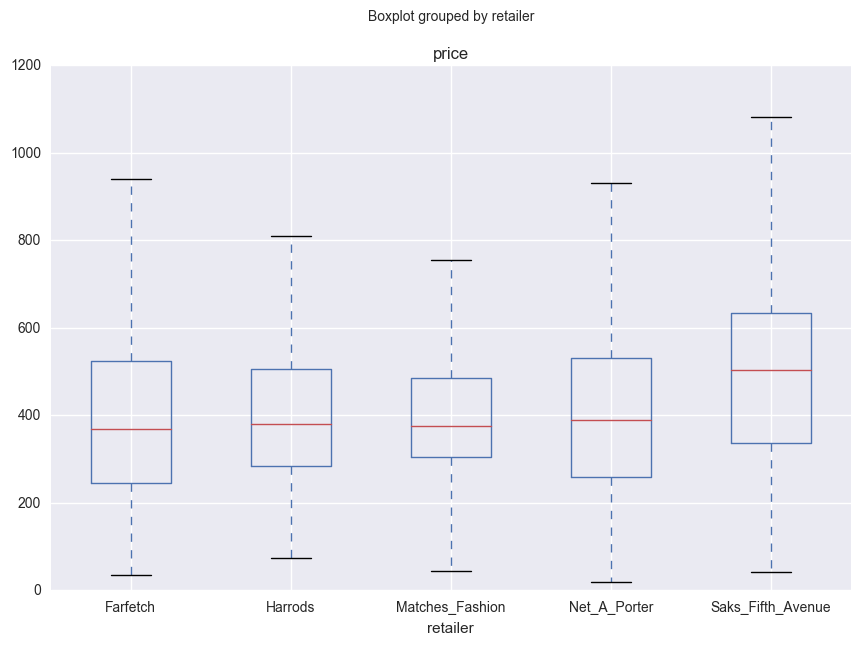

In [32]:
## Plotting a box plot of price of all of the shoes by each of the retailers.
fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(111)
Data.boxplot(column='price',by='retailer',ax=ax1)
ax1.set_ylim(0,1200)

The box-plot above shows each of the retailers and the distribution of prices of shoes that they stock. From the plot we can see that Matches Fashion has the shortest spread of price, and the lowest mean. The majority of retailers mean price is around the £420 mark, apart from Saks Fifth Avenue, which has a much higher value, this is also refelected in the much higher quartile spread. Farfetch which has the largest stock by a significant margin, has the highest max and and second largest spread of data. Below is a table summarising the key attributes.

In [33]:
pd.pivot_table(Data,columns='retailer',aggfunc={'brand':'count','price':[np.mean,np.std,max,min]})

retailer        Farfetch      Harrods  Matches_Fashion  Net_A_Porter  \
brand count  6220.000000  1032.000000       666.000000   1049.000000   
price max    5500.000000  4795.000000      1395.000000   1760.000000   
      mean    421.478939   439.802132       407.139640    424.911344   
      min      34.000000    74.950000        45.000000     20.000000   
      std     309.872355   332.363426       161.598519    260.788076   

retailer     Saks_Fifth_Avenue  
brand count        1454.000000  
price max          2151.130000  
      mean          503.400072  
      min            40.890000  
      std           259.571380

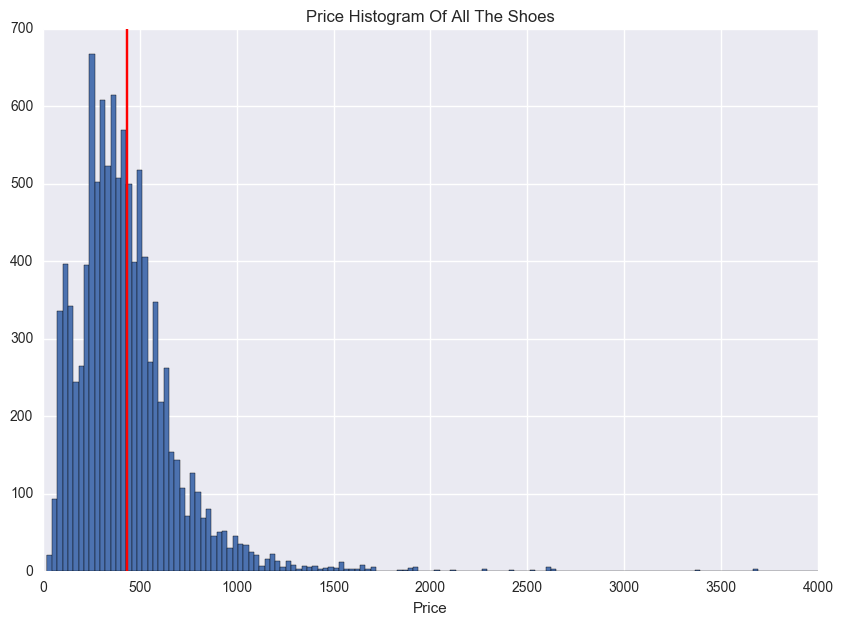

In [34]:
## Plotting a distribution of all the shoe prices across each of the retailers
fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(111)
Data.price.hist(bins=200,ax=ax1)
ax1.set_title('Price Histogram Of All The Shoes')
ax1.set_xlim(0,4000)
ax1.set_xlabel('Price')
ax1.axvline(x=Data.price.mean(),c='r')

The overall price data is normally distrubed with a large positive skew with very few shoes priced over £1500 it will be interesting to see if that the expensive shoes are distributed amongst a variety of brands or just one or two.

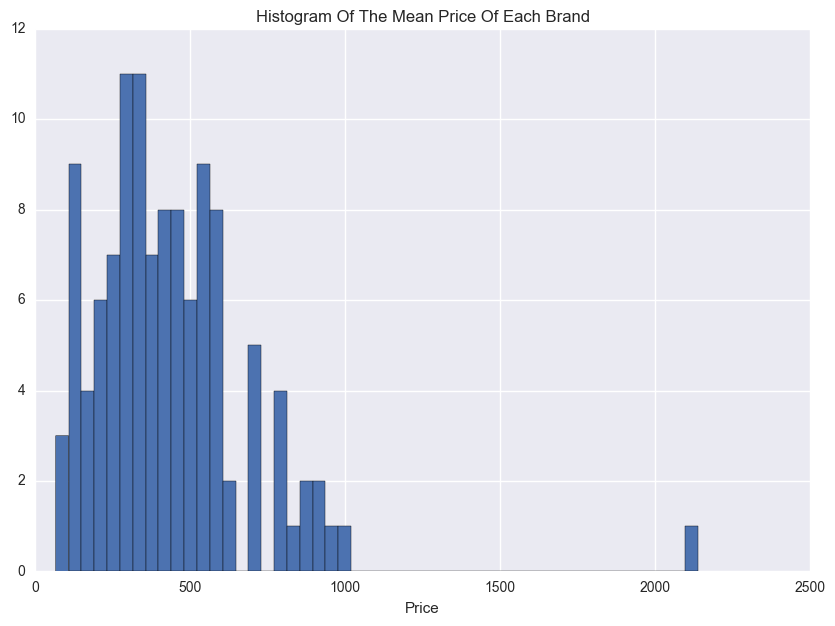

In [35]:
## Plot a histogram of the mean price of shoes for each brand.
fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(111)
pd.pivot_table(Data,columns='brand',values='price').sort_values(ascending=False).hist(bins=50,ax=ax1)
ax1.set_title('Histogram Of The Mean Price Of Each Brand')
ax1.set_xlim(0,2500)
ax1.set_xlabel('Price')

From the chart above we can see there is a clear outlier brand that sells extremely expensive shoes. Interestingly there are also some small gaps in the distribution between the range of £600-£750, I imagine that this is due to the market that these brands occupy, brands will either target the generic luxury market where the mean is around the £500 mark, or they will market themselves at the top with asking prices of over £1000 for some pairs.

In [36]:
## Create a dataframe with all of the brands, the mean price their shoes sell at, the number of shoes and 
## the standard deviation.
All_Brands=pd.pivot_table(Data,
                           index='brand',
                           aggfunc={'id':'count',
                                    'price':[np.mean,np.std]})

All_Brands=All_Brands.reset_index()
All_Brands.columns=[' '.join(col).strip() for col in All_Brands.columns.values]

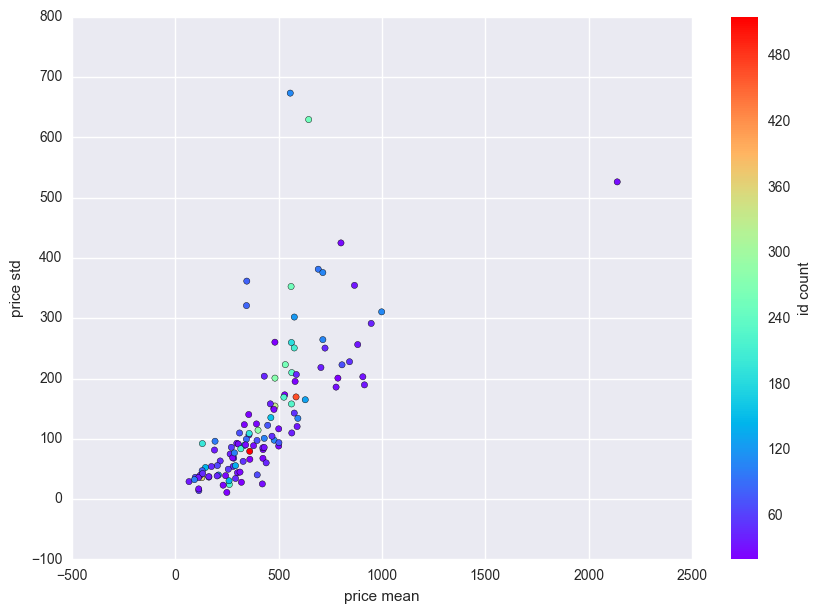

In [37]:
## Plot mean vs standard deviation of the price for all of the brands.
fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(111)
All_Brands.plot(x='price mean',
                 y='price std',
                 kind='scatter',
                 c='id count',
                 cmap='rainbow',
                 ax=ax1)

There is a huge gap between the highest brand 'a diciannoveventitre' and the rest, with over double the mean and the htird highest standard deviaiton standard deviation. There are also two brands with a very large standard deviation, which is un-expected, as one would assume that brands tended to focus on one price band of the market as in order to maintain a brand value. These outlier brands are detailed below.

In [38]:
## List the top 5 brands by mean price.
All_Brands.sort_values(by='price mean',ascending=False).head()

,brand,price mean,price std,id count
0,a diciannoveventitre,2138.000000,526.199089,28
51,guidi,998.145455,310.574219,110
16,berluti,947.547619,291.338559,42
102,thom browne,914.941176,189.413919,34
37,edward green,907.068125,202.871088,32


In [39]:
## List the top 5 brands by price standard deviation.
All_Brands.sort_values(by='price std',ascending=False).head()

,brand,price mean,price std,id count
72,myswear,555.909091,673.445945,110
94,santoni,645.018261,629.587649,253
0,a diciannoveventitre,2138.000000,526.199089,28
8,ann demeulemeester,801.222222,424.920204,27
80,philipp plein,691.364583,381.288180,96


I will now examine each retailer seperatly to see if they have the similar distribution of brands. 

In [40]:
## Creating a Saks_Brands table that will contain only brands in Saks Fifth Avenue and their numerical data.
Saks_Brands=pd.pivot_table(Data[Data.retailer=='Saks_Fifth_Avenue'],
                           index='brand',
                           aggfunc={'id':'count',
                                    'price':[np.mean,np.std]})
Saks_Brands=Saks_Brands.reset_index()
Saks_Brands.columns=[' '.join(col).strip() for col in Saks_Brands.columns.values]
Saks_Brands.head()

,brand,price mean,price std,id count
0,a. testoni,529.049500,172.876097,20
1,adidas by raf simons,332.253077,27.930113,13
2,alexander mcqueen,598.836389,153.325456,36
3,android homme,381.013529,149.544010,17
4,bally,482.193818,122.954009,55


In [41]:
## Creating a Net_Brands table that will contain only brands in Net-A-Porter and their numerical data.
Net_Brands=pd.pivot_table(Data[Data.retailer=='Net_A_Porter'],
                           index='brand',
                           aggfunc={'id':'count',
                                    'price':[np.mean,np.std]})
Net_Brands=Net_Brands.reset_index()
Net_Brands.columns=[' '.join(col).strip() for col in Net_Brands.columns.values]
Net_Brands.head()

,brand,price mean,price std,id count
0,adidas,84.250000,16.163230,20
1,alexander mcqueen,433.863636,97.234765,22
2,armando cabral,442.500000,91.419363,6
3,asics,104.000000,4.594683,10
4,balenciaga,383.750000,62.436925,24


In [42]:
## Creating a Har_Brands table that will contain only brands in Harrods and their numerical data.
Har_Brands=pd.pivot_table(Data[Data.retailer=='Harrods'],
                           index='brand',
                           aggfunc={'id':'count',
                                    'price':[np.mean,np.std]})
Har_Brands=Har_Brands.reset_index()
Har_Brands.columns=[' '.join(col).strip() for col in Har_Brands.columns.values]
Har_Brands.head()

,brand,price mean,price std,id count
0,adidas,134.491667,47.724021,12
1,alexander mcqueen,397.500000,78.056756,8
2,asics,120.000000,NaN,1
3,bottega veneta,451.212121,62.149395,33
4,brunello cucinelli,603.333333,94.162979,6


In [43]:
## Creating a Mats_Brands table that will contain only brands in Matches Fashion and their numerical data.
Mat_Brands=pd.pivot_table(Data[Data.retailer=='Matches_Fashion'],
                           index='brand',
                           aggfunc={'id':'count',
                                    'price':[np.mean,np.std]})
Mat_Brands=Mat_Brands.reset_index()
Mat_Brands.columns=[' '.join(col).strip() for col in Mat_Brands.columns.values]
Mat_Brands.head()

,brand,price mean,price std,id count
0,adidas by raf simons,205.000000,20.736441,6
1,alexander mcqueen,421.388889,90.599402,18
2,armando cabral,410.666667,66.275040,15
3,balenciaga,400.833333,110.777395,48
4,balmain,595.000000,47.696960,3


In [44]:
## Creating a Far_Brands table that will contain only brands in Farfetch and their numerical data.
Far_Brands=pd.pivot_table(Data[Data.retailer=='Farfetch'],
                           index='brand',
                           aggfunc={'id':'count',
                                    'price':[np.mean,np.std]})
Far_Brands=Far_Brands.reset_index()
Far_Brands.columns=[' '.join(col).strip() for col in Far_Brands.columns.values]
Far_Brands.head()

,brand,price mean,price std,id count
0,a diciannoveventitre,2138.000000,526.199089,28
1,adidas,136.042424,98.217364,165
2,adidas by raf simons,241.636364,75.387599,22
3,alberto fasciani,476.875000,150.433667,24
4,alexander mcqueen,418.171429,100.747060,70


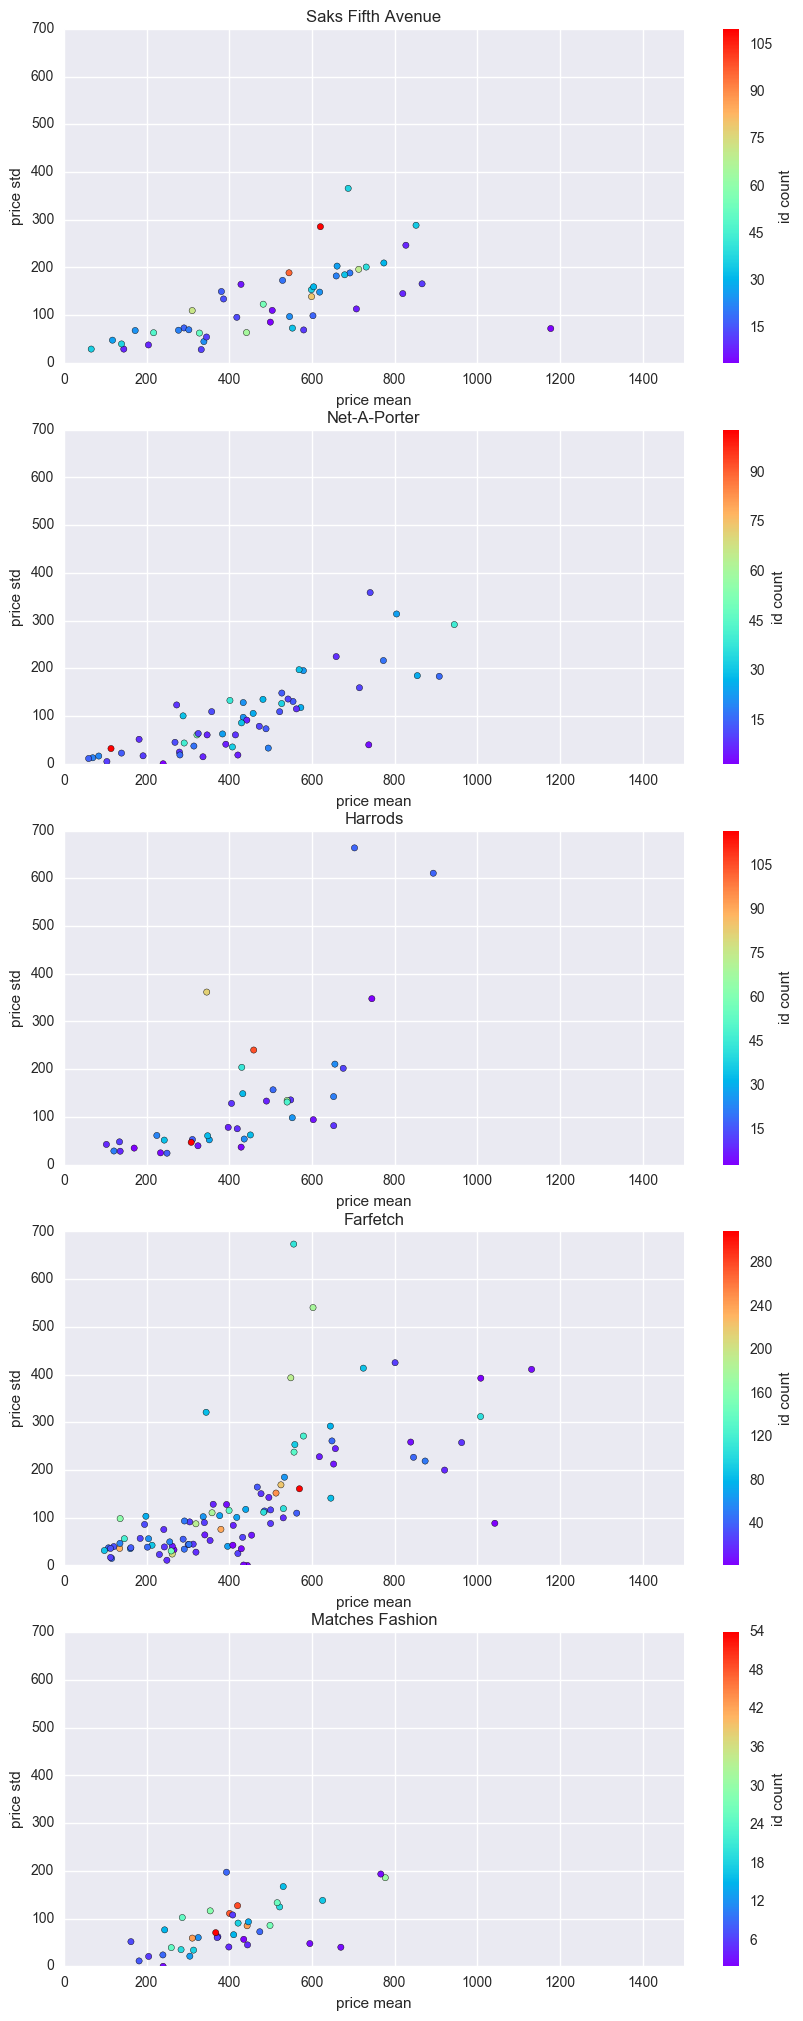

In [45]:
## Plotting the data aquired in the retailer tables above.
fig=plt.figure(figsize=(10,25))
ax1=fig.add_subplot(511)
ax2=fig.add_subplot(512)
ax3=fig.add_subplot(513)
ax4=fig.add_subplot(514)
ax5=fig.add_subplot(515)
Saks_Brands.plot(x='price mean',y='price std',kind='scatter',c='id count',cmap='rainbow',ax=ax1)
ax1.set_xlim(0,1500)
ax1.set_ylim(0,700)
ax1.set_title('Saks Fifth Avenue')
Net_Brands.plot(x='price mean',y='price std',kind='scatter',c='id count',cmap='rainbow',ax=ax2)
ax2.set_xlim(0,1500)
ax2.set_ylim(0,700)
ax2.set_title('Net-A-Porter')
Har_Brands.plot(x='price mean',y='price std',kind='scatter',c='id count',cmap='rainbow',ax=ax3)
ax3.set_xlim(0,1500)
ax3.set_ylim(0,700)
ax3.set_title('Harrods')
Far_Brands.plot(x='price mean',y='price std',kind='scatter',c='id count',cmap='rainbow',ax=ax4)
ax4.set_xlim(0,1500)
ax4.set_ylim(0,700)
ax4.set_title('Farfetch')
Mat_Brands.plot(x='price mean',y='price std',kind='scatter',c='id count',cmap='rainbow',ax=ax5)
ax5.set_xlim(0,1500)
ax5.set_ylim(0,700)
ax5.set_title('Matches Fashion')

From the graphs above we can see that there is quite an even spread of brands at each of the retailers as would be expected, however there are some subtle differences.
The chart directly above shows that Matches Fashion tends to stock only mid-range brands, with very few on the higher or lower end of the spectrum. Farfetch has a wide range, which is expected due to the large number of shoes it stocks. Both Net-A-Porter and Saks tend to stock a full range of brands and harrods mostly low-mid range.

I will now find out what brands are stock at all of the different retails in order to compare the prices that these retailers sell the brands for.

In [46]:
## I will merge all of the brand dataframs into a single dataframe, I will use an inner join so that I will be
## left with only the brands that are shared by all of the retailers.
Merged_Brands=pd.merge(Saks_Brands,Net_Brands,how='inner',on='brand',suffixes=('_Sak','_Net'))
Merged_Brands2=pd.merge(Far_Brands,Har_Brands,how='inner',on='brand',suffixes=('_Far','_Har'))
Merged_Brands=pd.merge(Merged_Brands,Merged_Brands2,how='inner',on='brand')
Merged_Brands=pd.merge(Merged_Brands,Mat_Brands,how='inner',on='brand',suffixes=('','_Mat'))
Merged_Brands.head()

,brand,price mean_Sak,price std_Sak,id count_Sak,price mean_Net,price std_Net,id count_Net,price mean_Far,price std_Far,id count_Far,price mean_Har,price std_Har,id count_Har,price mean,price std,id count
0,alexander mcqueen,598.836389,153.325456,36,433.863636,97.234765,22,418.171429,100.747060,70,397.500000,78.056756,8,421.388889,90.599402,18
1,brunello cucinelli,866.484167,165.729696,12,740.909091,358.676861,11,656.800000,244.835280,15,603.333333,94.162979,6,670.000000,40.000000,3
2,church's,580.025833,69.015811,12,357.500000,109.201648,12,513.132000,151.731355,250,351.724138,51.931890,29,353.965517,116.270461,29
3,dolce & gabbana,691.890952,188.451473,21,554.285714,130.529353,14,548.926702,393.308149,191,548.636364,135.592974,11,530.625000,167.171319,16
4,ermenegildo zegna,552.852727,72.872761,33,542.272727,135.634871,11,434.600000,0.894427,5,436.250000,53.573395,24,444.200000,44.929945,5


In [47]:
## I will now manipulate the dataframe in order to plot the data.

## Creating a list of column headers for each of the measures.
Mean_Rows= [k for k in Merged_Brands.columns if 'mean' in k]
Std_Rows=[k for k in Merged_Brands.columns if 'std' in k]
Count_Rows=[k for k in Merged_Brands.columns if 'count' in k]

## Create a dataframe with only the mean values for each brand for each retailer.
Merged_Brands_Mean=Merged_Brands.drop((Std_Rows+Count_Rows),axis=1)
Merged_Brands_Mean.index = Merged_Brands_Mean.iloc[:,0]
Merged_Brands_Mean=Merged_Brands_Mean.drop('brand',axis=1)
Merged_Brands_Mean

,price mean_Sak,price mean_Net,price mean_Far,price mean_Har,price mean
brand,,,,,
alexander mcqueen,598.836389,433.863636,418.171429,397.500000,421.388889
brunello cucinelli,866.484167,740.909091,656.800000,603.333333,670.000000
church's,580.025833,357.500000,513.132000,351.724138,353.965517
dolce & gabbana,691.890952,554.285714,548.926702,548.636364,530.625000
ermenegildo zegna,552.852727,542.272727,434.600000,436.250000,444.200000
givenchy,687.763243,481.607143,558.739130,419.400000,521.842105
lanvin,545.946667,401.666667,399.576642,347.727273,367.277778
maison margiela,731.384000,433.863636,579.528455,405.454545,446.428571
paul smith,302.231429,314.411765,302.420000,242.794118,313.611111


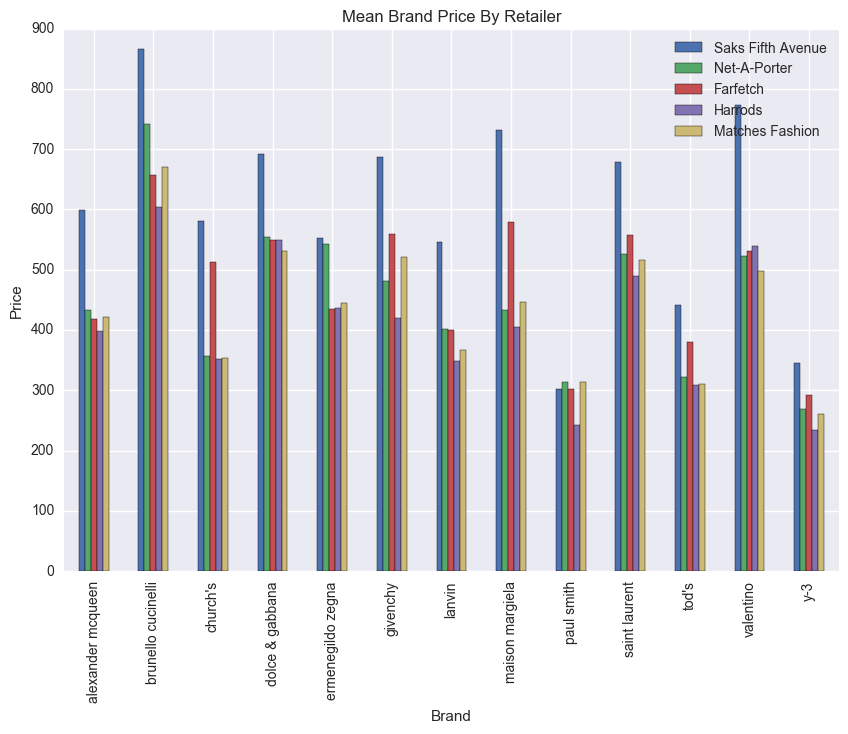

In [48]:
## Plot the data from the mean dataframe
fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(111)
Merged_Brands_Mean.plot(kind='bar',ax=ax1)
ax1.legend(['Saks Fifth Avenue','Net-A-Porter','Farfetch','Harrods','Matches Fashion'])
ax1.set_title('Mean Brand Price By Retailer')
ax1.set_ylabel('Price')
ax1.set_xlabel('Brand')

The chart above is very interesting. It appears to show that Harrods is the cheapest retailer to buy almost all of the common brands from which goes against what I imagine the general consensus would be. It may be a case that Harrods only stock the cheaper end of shoes from each brand, but this is also suprising. On the other end Saks is by far the most expensive with the exception of the brand Paul Smtih, this is possibly due to Saks being an american retailer so the price in pounds includes some extra taxes. of the british and european ecommerce sites, Net-A-Porter and Farfetch tend to cost the most.

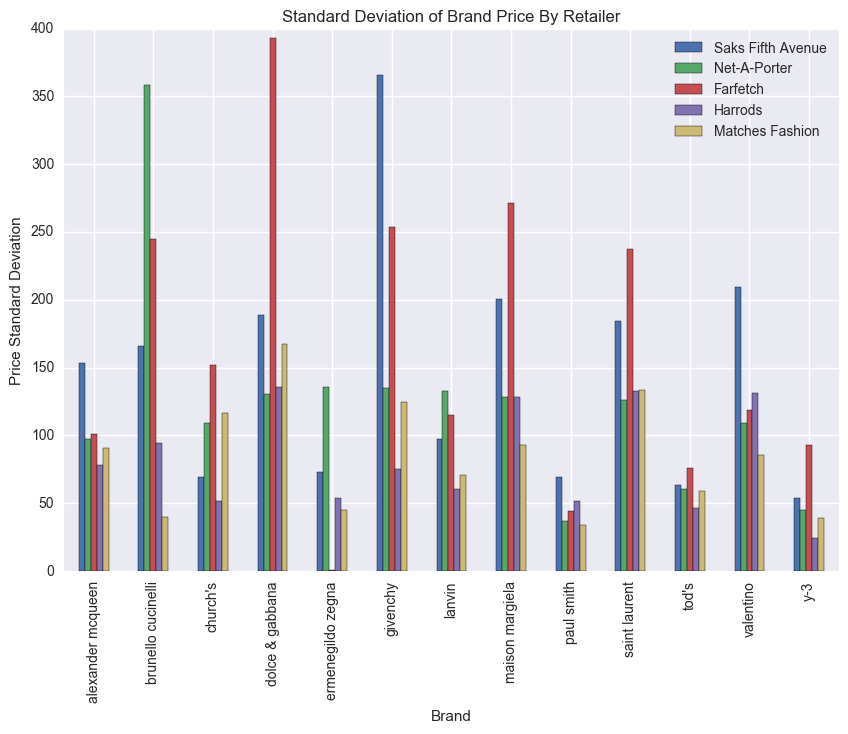

In [49]:
Merged_Brands_Std=Merged_Brands.drop((Mean_Rows+Count_Rows),axis=1)
Merged_Brands_Std.index = Merged_Brands_Std.iloc[:,0]
Merged_Brands_Std=Merged_Brands_Std.drop('brand',axis=1)
fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(111)
Merged_Brands_Std.plot(kind='bar',ax=ax1)
ax1.legend(['Saks Fifth Avenue','Net-A-Porter','Farfetch','Harrods','Matches Fashion'])
ax1.set_title('Standard Deviation of Brand Price By Retailer')
ax1.set_ylabel('Price Standard Deviation')
ax1.set_xlabel('Brand')

This chart does not tell us quite as much, it is clear that as expected Farfetch tend to stock a full range of the brand items with Saks following suit. Harrods, Net-A-Porter and Matches fashion tend to select a much narrower price band from each of the brands.

I will now take a brief look at shoe type and the associated mean cost and standard deviation. I will intially assign each shoe a shoe type if the description string contains that type, I will create two columns, for two key type words as in some cases the shoes will be described by two key words such as 'monk boots'. I have order the shoe types so that the key descriptor is first and more generic terms are left until the end such as 'trainers' and 'boots' this will hopefully allow me to just use the type_1 column in the event of a classification process.

In [50]:
## Define the shoe 'type' key words in order
Shoe_Types=[u'hightops',u'loafers',u'derby',u'slip',u'brogues',u'ankle',u'oxfords',u'chelsea',u'monk',
            u'slippers',u'driving',u'gommino',u'drivers',u'chukka',u'sandals',u'sneakers',u'boots',
            u'lace',u'trainers']
## Creating a function that searches through the shoe type list, and if the type is found returns the type.
def shoe_type1(Inp_Str,Types):
    for x in Types:
        if x in Inp_Str:
            return x
## Creating a function that searches through the shoe type list, and if the type is found returns the type IF 
## the type has not already been assigned
def shoe_type2(Inp_Str,Type1,Types):
    if Type1 in Types:
        Types.remove(Type1)
        for x in Types:
            if x in Inp_Str:
                return x

In [51]:
## Applying the functions above to the data set
Data['type_1']=Data.description.map(lambda x:shoe_type1(x,Shoe_Types))
Data['type_2']=Data.apply(lambda x:shoe_type2(x['description'],x['type_1'],Shoe_Types),axis=1)
## One shoe type I missed that needs to be aggregated is drivers and driving this is done below
Data.type_1=Data.type_1.map(lambda x: 'drivers' if x=='driving' else x)
Data.type_2=Data.type_2.map(lambda x: 'drivers' if x=='driving' else x)
Data.head()

,id,brand,retailer,description,image_url,image_url_alt,price,date,type_1,type_2
0,728,alexander mcqueen,Matches_Fashion,raised sole hightops leather trainers,http://assetsprx.matchesfashion.com/img/produc...,http://assetsprx.matchesfashion.com/img/produc...,395.0,2016-11-22,hightops,trainers
1,729,armando cabral,Matches_Fashion,lace up leather derby shoes,http://assetsprx.matchesfashion.com/img/produc...,http://assetsprx.matchesfashion.com/img/produc...,405.0,2016-11-22,derby,lace
2,730,bottega veneta,Matches_Fashion,intrecciato leather loafers,http://assetsprx.matchesfashion.com/img/produc...,http://assetsprx.matchesfashion.com/img/produc...,380.0,2016-11-22,loafers,None
3,731,armando cabral,Matches_Fashion,lizard effect leather ankle boots,http://assetsprx.matchesfashion.com/img/produc...,http://assetsprx.matchesfashion.com/img/produc...,530.0,2016-11-22,ankle,boots
4,732,burberry,Matches_Fashion,owen tread sole canvas boots,http://assetsprx.matchesfashion.com/img/produc...,http://assetsprx.matchesfashion.com/img/produc...,350.0,2016-11-22,boots,None


In [52]:
## Calculating mean, standard deviation and count for the whole dataset for each shoe type.
Shoe_Type_Attributes=pd.pivot_table(Data,index='type_1',aggfunc={'id':'count','price':[np.mean,np.std]})
Shoe_Type_Attributes=Shoe_Type_Attributes.reset_index()
Shoe_Type_Attributes.columns=[' '.join(col).strip() for col in Shoe_Type_Attributes.columns.values]
Shoe_Type_Attributes.head()

,type_1,price mean,price std,id count
0,ankle,604.087678,358.877657,323
1,boots,605.890651,363.514295,784
2,brogues,508.072599,214.905487,377
3,chelsea,503.149190,202.921028,284
4,chukka,361.939490,162.070856,98


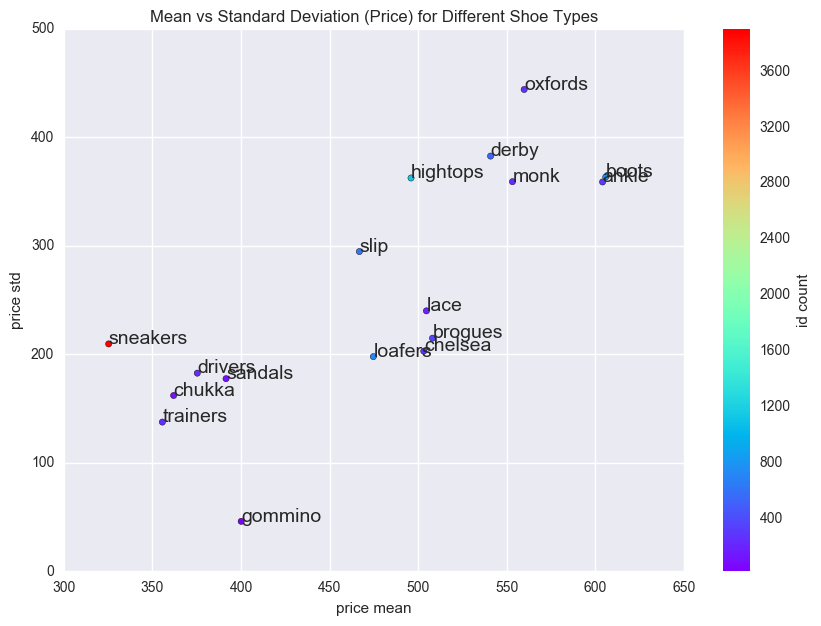

In [53]:
## Plotting the data from above.
fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(111)
Shoe_Type_Attributes.plot(x='price mean',
                          y='price std',
                          kind='scatter',
                          c='id count',
                          cmap='rainbow',
                          ax=ax1)
## Annotating the type of shoe on to each point.
for i, xi in enumerate(Shoe_Type_Attributes.type_1):
    ax1.annotate(xi, 
                 (Shoe_Type_Attributes.iloc[i,1], 
                  Shoe_Type_Attributes.iloc[i,2]),
                 fontsize=14)
ax1.set_title('Mean vs Standard Deviation (Price) for Different Shoe Types')

In this plot we can see the various types of shoe, their mean price and stanard deviation. We can also so which shoes are most popular. Across all the sites sneakers holds the largest market share, which may be unexpected for luxury fashion goods. It is interesting to note that all of the shoes follow a pattern of a higher mean going hand in hand with a higher stnadard deviation, I would have thought that some types of shoes such as derby or oxford shoes would not vary as much compared to their mean as some other types.

In [54]:
Data.to_sql('mens_shoes_cleaned',engine,if_exists='append',index=False)